# Análise de Resultados: C-SILSP (PLIM vs. GRASP)

1.  **Comparação direta de Gaps (PLIM vs GRASP)**
2.  **Análise da "Muralha" de escalabilidade do PLIM**
3.  **Análise de Convergência (Time-to-Target Plots)**

## 1. Setup: Importação e Carregamento

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import os
from pathlib import Path

sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['font.size'] = 12
pd.options.display.float_format = '{:,.2f}'.format

print("Bibliotecas importadas com sucesso.")

Bibliotecas importadas com sucesso.


## 2. Limpeza e Fusão dos Dados

In [10]:
path_mip = 'benchmark/resultados_mip.csv'
path_grasp = 'benchmark/resultados_grasp.csv'

try:
    df_mip = pd.read_csv(path_mip)
    df_grasp = pd.read_csv(path_grasp)
    print(f"Carregado: {path_mip} ({len(df_mip)} linhas)")
    print(f"Carregado: {path_grasp} ({len(df_grasp)} linhas)")
except FileNotFoundError:
    print("Erro: Arquivos CSV não encontrados. Verifique os caminhos.")

key_cols = ['classe', 'arquivo', 'T', 'tau', 'var']

df = pd.merge(df_mip, df_grasp, on=key_cols, suffixes=('_mip', '_grasp'))
print(f"\nLinhas antes da filtragem: {len(df)}")

df_clean = df[df['status'] != 'INFEASIBLE'].copy()

df_clean = df_clean[df_clean['factivel_grasp'] == 1]
df_clean = df_clean[df_clean['custo_grasp'] < 1e12]

print(f"Linhas após filtrar infactíveis (MIP e GRASP): {len(df_clean)}")

df_clean['custo_mip'] = pd.to_numeric(df_clean['custo_mip'], errors='coerce')
df_clean['bound_mip'] = pd.to_numeric(df_clean['bound_mip'], errors='coerce')
df_clean['custo_grasp'] = pd.to_numeric(df_clean['custo_grasp'], errors='coerce')

df_clean['custo_mip'] = df_clean['custo_mip'].fillna(np.inf)
df_clean['custo_grasp'] = df_clean['custo_grasp'].fillna(np.inf)
df_clean['bound_mip'] = df_clean['bound_mip'].fillna(0)

print("\n--- Informações do Dataframe Limpo ---")
df_clean.info()

Carregado: benchmark/resultados_mip.csv (240 linhas)
Carregado: benchmark/resultados_grasp.csv (240 linhas)

Linhas antes da filtragem: 240
Linhas após filtrar infactíveis (MIP e GRASP): 213

--- Informações do Dataframe Limpo ---
<class 'pandas.core.frame.DataFrame'>
Index: 213 entries, 0 to 239
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   classe           213 non-null    object 
 1   arquivo          213 non-null    object 
 2   T                213 non-null    int64  
 3   tau              213 non-null    float64
 4   var              213 non-null    float64
 5   status           213 non-null    object 
 6   custo_mip        213 non-null    float64
 7   bound_mip        213 non-null    float64
 8   gap_rel          213 non-null    float64
 9   tempo_seg_mip    213 non-null    float64
 10  custo_grasp      213 non-null    float64
 11  factivel_grasp   213 non-null    int64  
 12  tempo_seg_grasp  213

## 3. Análise de Qualidade (Performance Profiles)

O **Performance Profile** (Perfil de Performance) é um método para comparar solvers de otimização. Ele responde à pergunta: 

> "Qual a probabilidade $P(r)$ de um *solver* estar, no máximo, $r$ vezes pior que o melhor *solver* para uma dada instância?"

Um *solver* que está mais próximo de $r=1$ no gráfico é considerado melhor, pois resolve mais instâncias com alta qualidade. Perceba que todas as instâncias de gurobi estão iguais a 1.


--- Gerando Performance Profile (Seção 3) ---


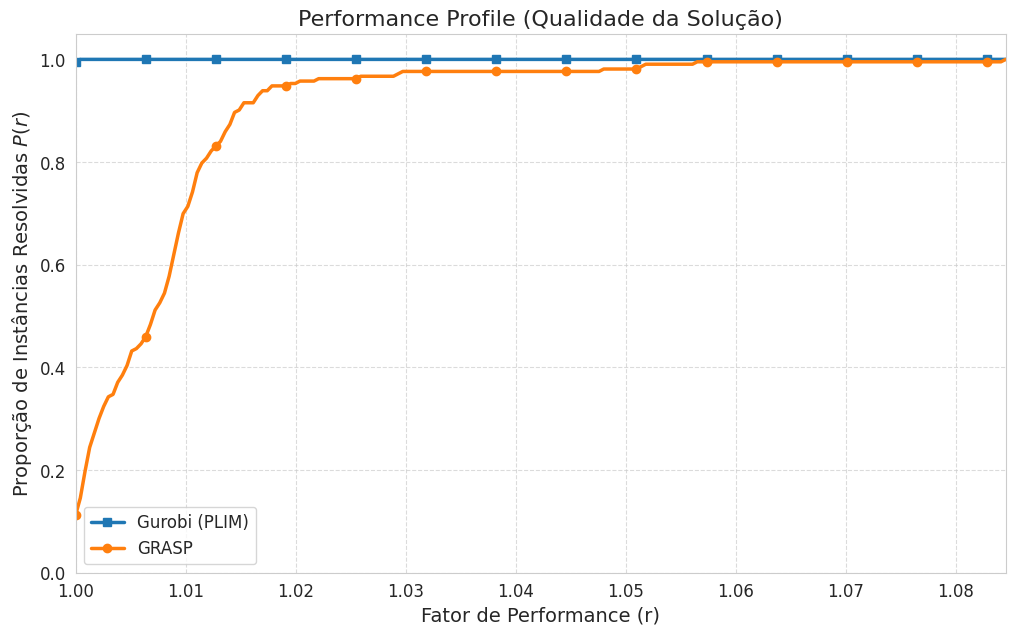

In [11]:
print("\n--- Gerando Performance Profile (Seção 3) ---")

df_perf = df_clean.copy()
df_perf = df_perf[(df_perf['custo_mip'] < np.inf) & (df_perf['custo_grasp'] < np.inf)]

df_perf['best_cost'] = df_perf[['custo_mip', 'custo_grasp']].min(axis=1)

epsilon = 1e-9
df_perf['r_mip'] = df_perf['custo_mip'] / (df_perf['best_cost'] + epsilon)
df_perf['r_grasp'] = df_perf['custo_grasp'] / (df_perf['best_cost'] + epsilon)

max_ratio = max(df_perf['r_mip'].max(), df_perf['r_grasp'].max())
plot_max_r = min(max_ratio, 2.0)
r_axis = np.linspace(1, plot_max_r, 200)

n_problems = len(df_perf)
cdf_mip = [ (df_perf['r_mip'] <= r).sum() / n_problems for r in r_axis ]
cdf_grasp = [ (df_perf['r_grasp'] <= r).sum() / n_problems for r in r_axis ]

plt.figure(figsize=(12, 7))
plt.plot(r_axis, cdf_mip, label='Gurobi (PLIM)', lw=2.5, marker='s', markevery=15, ms=6)
plt.plot(r_axis, cdf_grasp, label='GRASP', lw=2.5, marker='o', markevery=15, ms=6)
plt.title('Performance Profile (Qualidade da Solução)', fontsize=16)
plt.xlabel('Fator de Performance (r)', fontsize=14)
plt.ylabel('Proporção de Instâncias Resolvidas $P(r)$', fontsize=14)
plt.legend(fontsize=12)
plt.grid(True, which='both', linestyle='--', alpha=0.7)
plt.xlim(1, plot_max_r)
plt.ylim(0, 1.05)
plt.show()

## 4. Análise de Escalabilidade (PLIM vs. GRASP)

Aqui investigamos como os métodos se comportam à medida que o problema cresce (o horizonte `T` aumenta).

A **escalabilidade** é crucial; um método pode ser ótimo para problemas pequenos (`T=50`), mas completamente inútil para os grandes (`T=500`). Analisamos isso de três formas: tempo de execução, status da solução (ótimo vs. limite de tempo) e qualidade da solução (gap).


--- Gerando Análise de Escalabilidade (Seção 4) ---


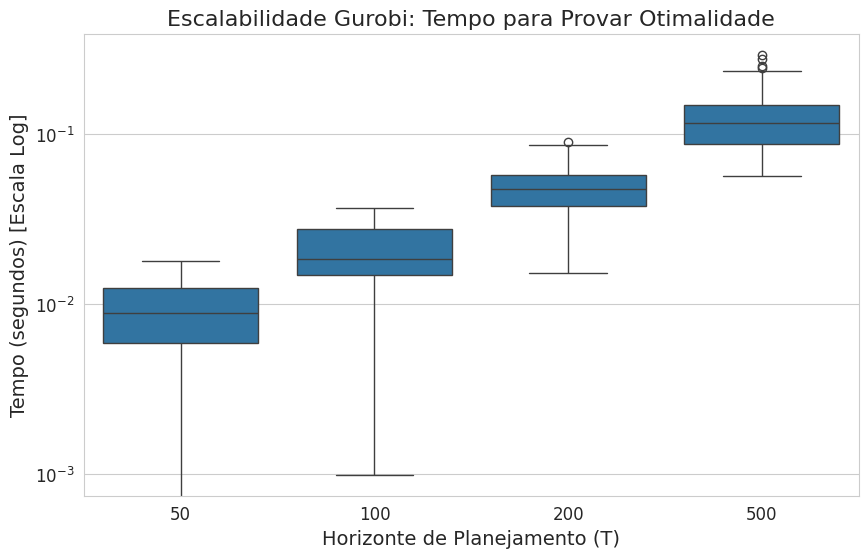

In [12]:
print("\n--- Gerando Análise de Escalabilidade (Seção 4) ---")

### --------------------------------------------------------------
### 4.1. Escalabilidade do Tempo (Gurobi - 'OPTIMAL')
### --------------------------------------------------------------
df_optimal = df_clean[df_clean['status'] == 'OPTIMAL'].copy()

plt.figure(figsize=(10, 6))
df_optimal['T_cat'] = df_optimal['T'].astype(str)

T_numeric_order = sorted(df_optimal['T'].unique())
T_string_order = [str(t) for t in T_numeric_order]

sns.boxplot(data=df_optimal, x='T_cat', y='tempo_seg_mip', order=T_string_order)

plt.title('Escalabilidade Gurobi: Tempo para Provar Otimalidade', fontsize=16)
plt.xlabel('Horizonte de Planejamento (T)', fontsize=14)
plt.ylabel('Tempo (segundos) [Escala Log]', fontsize=14)
plt.yscale('log')
plt.show()

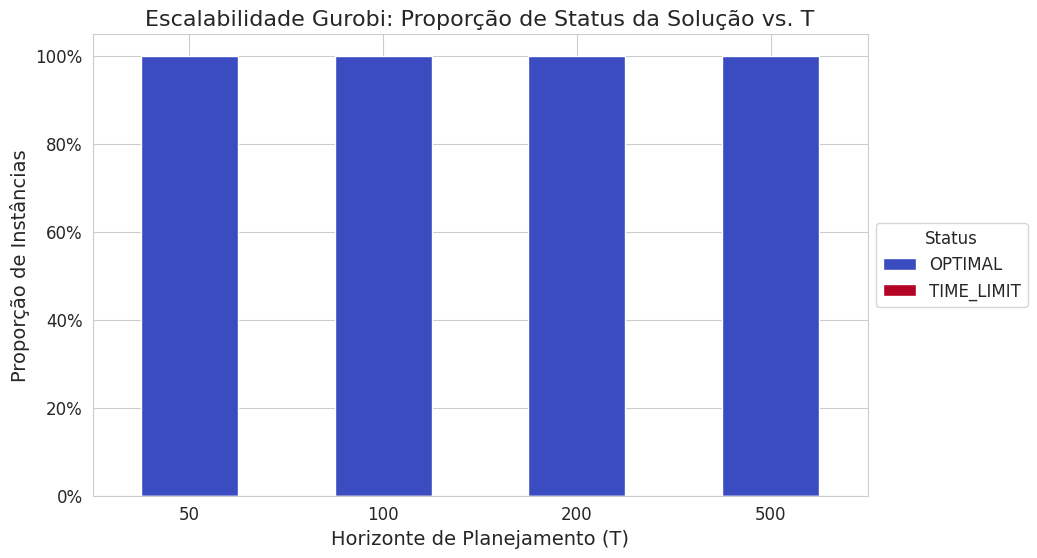

In [13]:
### --------------------------------------------------------------
### 4.2. (NOVA) Escalabilidade do Status (Muralha PLIM)
### --------------------------------------------------------------
status_counts = df_clean.groupby('T')['status'].value_counts(normalize=True).unstack().fillna(0)

status_to_plot = status_counts.reindex(columns=['OPTIMAL', 'TIME_LIMIT'], fill_value=0)

status_to_plot.plot(kind='bar', stacked=True, figsize=(10, 6), colormap='coolwarm')

plt.title('Escalabilidade Gurobi: Proporção de Status da Solução vs. T', fontsize=16)
plt.xlabel('Horizonte de Planejamento (T)', fontsize=14)
plt.ylabel('Proporção de Instâncias', fontsize=14)
plt.legend(title='Status', loc='center left', bbox_to_anchor=(1, 0.5))
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter('{:.0%}'.format))
plt.xticks(rotation=0)
plt.show()

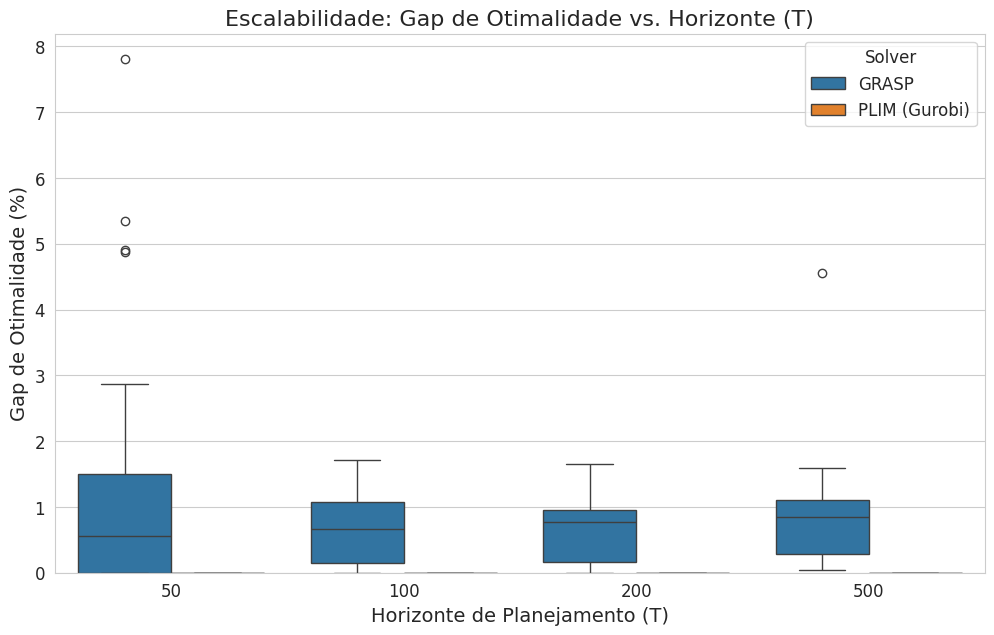

In [14]:
### --------------------------------------------------------------
### 4.3. (MODIFICADA) Escalabilidade da Qualidade (Gaps PLIM vs. GRASP)
### --------------------------------------------------------------

df_gap_analysis = df_perf[df_perf['bound_mip'] > 0].copy()

df_gap_analysis['gap_grasp_pct'] = 100 * (df_gap_analysis['custo_grasp'] - df_gap_analysis['bound_mip']) / df_gap_analysis['custo_grasp']
df_gap_analysis['gap_grasp_pct'] = df_gap_analysis['gap_grasp_pct'].clip(lower=0)

df_gap_analysis['gap_mip_pct'] = np.nan
time_limit_mask = df_gap_analysis['status'] == 'TIME_LIMIT'
df_gap_analysis.loc[time_limit_mask, 'gap_mip_pct'] = 100 * (df_gap_analysis.loc[time_limit_mask, 'custo_mip'] - df_gap_analysis.loc[time_limit_mask, 'bound_mip']) / df_gap_analysis.loc[time_limit_mask, 'custo_mip']
optimal_mask = df_gap_analysis['status'] == 'OPTIMAL'
df_gap_analysis.loc[optimal_mask, 'gap_mip_pct'] = 0.0
df_gap_analysis['gap_mip_pct'] = df_gap_analysis['gap_mip_pct'].clip(lower=0)

df_gap_analysis['T_cat'] = df_gap_analysis['T'].astype(str)
df_gap_analysis['tau_cat'] = df_gap_analysis['tau'].astype(str)
df_gap_analysis['var_cat'] = df_gap_analysis['var'].astype(str)

df_gaps_melted = pd.melt(df_gap_analysis,
                             id_vars=['T_cat', 'tau_cat', 'var_cat', 'status'],
                             value_vars=['gap_grasp_pct', 'gap_mip_pct'],
                             var_name='solver', value_name='gap_pct')

df_gaps_melted['solver'] = df_gaps_melted['solver'].map({'gap_grasp_pct': 'GRASP', 'gap_mip_pct': 'PLIM (Gurobi)'})

T_numeric_order = sorted(df_gap_analysis['T'].unique())
T_string_order = [str(t) for t in T_numeric_order]

plt.figure(figsize=(12, 7))
sns.boxplot(data=df_gaps_melted, x='T_cat', y='gap_pct', hue='solver',
            order=T_string_order)

plt.title('Escalabilidade: Gap de Otimalidade vs. Horizonte (T)', fontsize=16)
plt.xlabel('Horizonte de Planejamento (T)', fontsize=14)
plt.ylabel('Gap de Otimalidade (%)', fontsize=14)
plt.ylim(bottom=0)
plt.legend(title='Solver')
plt.show()

## 5. Análise de Dificuldade por Parâmetros (τ e CV)

Além do tamanho (`T`), analisamos a **dificuldade intrínseca** da instância. Usamos *boxplots* para ver como o Gap de Otimalidade (a diferença percentual do custo da solução para o melhor *bound* inferior conhecido) é afetado por:

* **Aperto de Capacidade (τ):** Quão restrita é a capacidade de produção (quanto menor o $\tau$, mais apertado).
* **Variabilidade da Demanda (CV):** Se a demanda é estável (CV baixo) ou errática (CV alto).

Isso nos ajuda a entender *em que cenário* cada *solver* se destaca ou sofre mais.


--- Gerando Análise de Dificuldade (Seção 5) ---


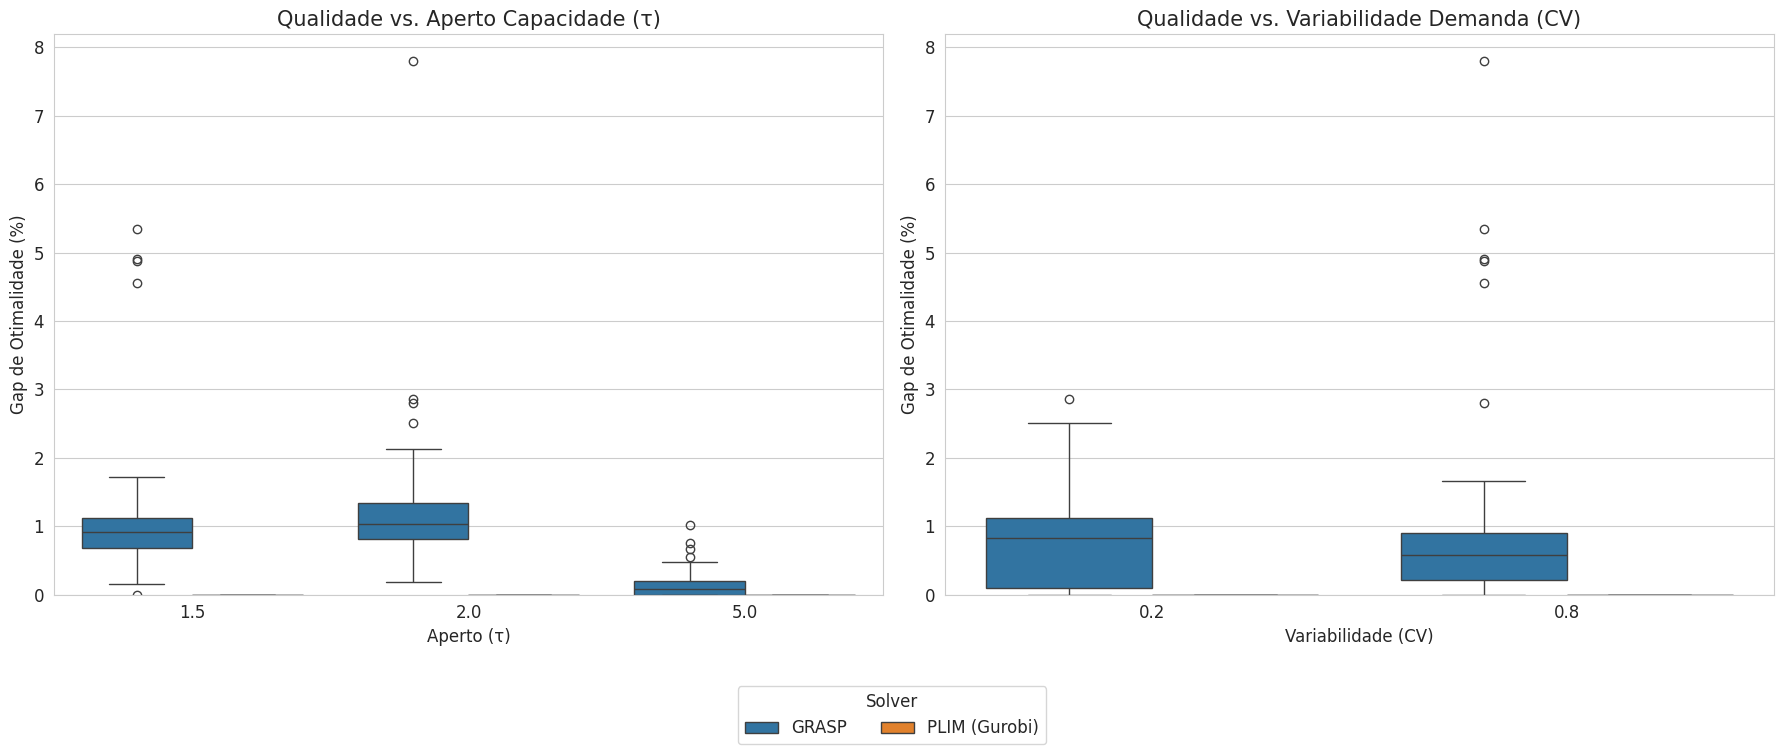

In [15]:
print("\n--- Gerando Análise de Dificuldade (Seção 5) ---")

fig, axes = plt.subplots(1, 2, figsize=(18, 7))

sns.boxplot(ax=axes[0], data=df_gaps_melted, x='tau_cat', y='gap_pct', hue='solver',
            order=sorted(df_gap_analysis['tau_cat'].unique()))
axes[0].set_title('Qualidade vs. Aperto Capacidade (τ)', fontsize=15)
axes[0].set_xlabel('Aperto (τ)', fontsize=12)
axes[0].set_ylabel('Gap de Otimalidade (%)', fontsize=12)
axes[0].set_ylim(bottom=0)
axes[0].legend().set_visible(False)

sns.boxplot(ax=axes[1], data=df_gaps_melted, x='var_cat', y='gap_pct', hue='solver',
            order=sorted(df_gap_analysis['var_cat'].unique()))
axes[1].set_title('Qualidade vs. Variabilidade Demanda (CV)', fontsize=15)
axes[1].set_xlabel('Variabilidade (CV)', fontsize=12)
axes[1].set_ylabel('Gap de Otimalidade (%)', fontsize=12)
axes[1].set_ylim(bottom=0)
axes[1].legend().set_visible(False)

handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, -0.02), ncol=2, title='Solver')

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

## 6. Análise de Convergência (Time-to-Target Plots)

O **Time-to-Target (TTT) Plot** é específico para heurísticas (como o GRASP). Enquanto o *Performance Profile* olha o resultado *final*, o TTT-Plot olha a *convergência*.

Ele plota uma ECDF (Função de Distribuição Cumulativa Empírica) do tempo necessário para o GRASP atingir uma solução dentro de um *gap* alvo (ex: 10%, 5%, 1%). Isso mostra o quão rápido o GRASP é em encontrar soluções "boas o suficiente", o que é uma de suas maiores vantagens.


--- Gerando Time-to-Target Plots (Seção 6) ---
Encontrados 240 arquivos de log do GRASP.


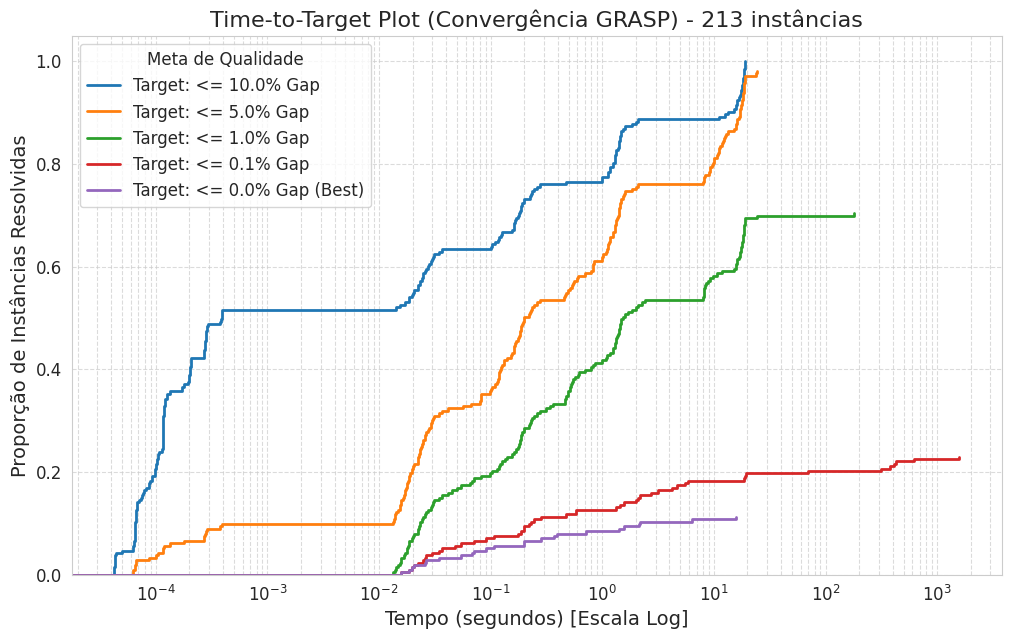


--- Análise de Resultados Concluída ---


In [16]:
print("\n--- Gerando Time-to-Target Plots (Seção 6) ---")

log_files = glob.glob('benchmark/grasp_logs/**/*.csv', recursive=True)
print(f"Encontrados {len(log_files)} arquivos de log do GRASP.")

all_logs = []
for f in log_files:
    try:
        parts = Path(f).parts
        classe = parts[-2]
        arquivo = parts[-1].replace('_log.csv', '.txt')

        df_log = pd.read_csv(f)
        df_log['classe'] = classe
        df_log['arquivo'] = arquivo
        all_logs.append(df_log)
    except Exception as e:
        print(f"Erro ao processar {f}: {e}")

df_logs_raw = pd.concat(all_logs, ignore_index=True)

df_logs_merged = pd.merge(df_logs_raw, df_perf[['classe', 'arquivo', 'best_cost']], on=['classe', 'arquivo'])

epsilon = 1e-9
df_logs_merged['gap_rel'] = (df_logs_merged['custo'] - df_logs_merged['best_cost']) / (df_logs_merged['best_cost'] + epsilon)

targets_pct = [10.0, 5.0, 1.0, 0.1, 0.0]
targets_rel = {pct: pct / 100.0 for pct in targets_pct}

ttt_data = []

for (classe, arquivo), group in df_logs_merged.groupby(['classe', 'arquivo']):
    for pct, rel_gap in targets_rel.items():
        solution_found = group[group['gap_rel'] <= (rel_gap + epsilon)]
        if not solution_found.empty:
            time_to_target = solution_found['tempo_seg'].min()
            ttt_data.append({
                'classe': classe,
                'arquivo': arquivo,
                'target_pct': pct,
                'time_to_target_seg': time_to_target
            })

df_ttt = pd.DataFrame(ttt_data)

plt.figure(figsize=(12, 7))

n_total_instances = len(df_perf)

for pct in sorted(targets_pct, reverse=True):
    data = df_ttt[df_ttt['target_pct'] == pct]['time_to_target_seg']
    if not data.empty:
        ecdf_x = np.sort(data)
        ecdf_y = np.arange(1, len(ecdf_x) + 1) / n_total_instances

        ecdf_x = np.insert(ecdf_x, 0, 0)
        ecdf_y = np.insert(ecdf_y, 0, 0)

        label = f"Target: <= {pct}% Gap"
        if pct == 0.0:
            label = f"Target: <= 0.0% Gap (Best)"

        plt.plot(ecdf_x, ecdf_y, label=label, drawstyle='steps-post', lw=2)

plt.title(f'Time-to-Target Plot (Convergência GRASP) - {n_total_instances} instâncias', fontsize=16)
plt.xlabel('Tempo (segundos) [Escala Log]', fontsize=14)
plt.ylabel('Proporção de Instâncias Resolvidas', fontsize=14)
plt.legend(title="Meta de Qualidade")
plt.xscale('log')
plt.grid(True, which='both', linestyle='--', alpha=0.7)
plt.ylim(0, 1.05)
plt.show()

print("\n--- Análise de Resultados Concluída ---")